## Initialization

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers

# Set seed for reproducibility
np.random.seed(12345)

## Load the data

The dataset is stored in the `/datasets/faces/` folder:
- The `final_files` folder contains 7600 photos
- The `labels.csv` file with labels, consisting of two columns: `file_name` and `real_age`
Since the number of image files is quite large, it is recommended to avoid reading them all at once, as this would consume a lot of computational resources. We recommend creating a generator using ImageDataGenerator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as a regular CSV file.

In [2]:
# Load label file
labels = pd.read_csv('/datasets/faces/labels.csv')

# Set up data generator with additional preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,             # Pixel normalization
    rotation_range=20,             # Random rotation of images
    width_shift_range=0.1,         # Horizontal shift
    height_shift_range=0.1,        # Vertical shift
    shear_range=0.2,               # Image shearing
    zoom_range=0.2,                # Random zoom
    horizontal_flip=True,          # Horizontal flip
    fill_mode='nearest'            # Pixel fill method
)

# Create training data flow with data augmentation techniques
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',             # Column with file names
    y_col='real_age',              # Column with labels (actual age)
    target_size=(224, 224),        # Image dimensions
    batch_size=32,                 # Batch size
    class_mode='raw',              # Output type for regression
    seed=12345                     # Seed for reproducibility
)

# Check the number of loaded images
print(f"Cantidad de imágenes encontradas: {train_gen_flow.samples}")

Found 7591 validated image filenames.
Cantidad de imágenes encontradas: 7591


## EDA

### Dataset Size
- Check the size of the dataset and review basic statistics

In [3]:
# Dataset size
print(f"Tamaño del conjunto de datos: {labels.shape}")

# Descriptive statistics of the 'real_age' column
print(labels['real_age'].describe())

Tamaño del conjunto de datos: (7591, 2)
count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


* The dataset has 7,591 records and 2 columns.
* The age of the subjects in the dataset has a mean of 31.2 years with a standard deviation of 17.1 years. This suggests that the age is variably distributed, with the mean falling within the range of young adults and middle-aged individuals.
* The minimum and maximum age values are 1 and 100 years, respectively, indicating that the dataset contains a wide variety of ages, though the extremes may need special handling (such as removing extreme ages that could be errors).

### Age Distribution

* Visualize the age distribution

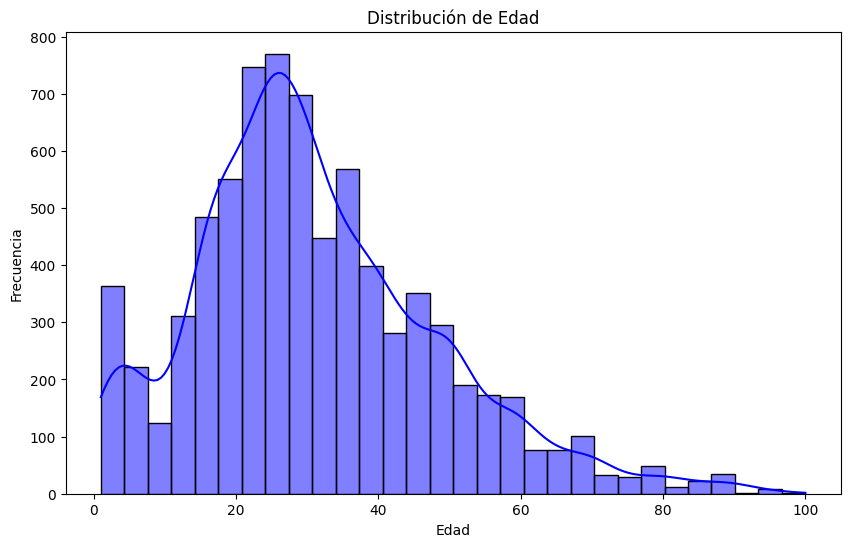

In [4]:
# Age distribution
plt.figure(figsize=(10, 6))
sns.histplot(labels['real_age'], bins=30, kde=True, color='blue')
plt.title('Distribución de Edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

* The histogram shows that the age distribution is asymmetric, with a peak in the 15-25 age range. This distribution suggests that most people in the dataset are young, and the frequency decreases as age increases.
* The probability density plot confirms that most records are grouped in the younger age range, while people over 60 years old are less common in this dataset.
* This type of youth-skewed distribution may have implications for the model. The model could be biased towards predicting characteristics associated with a younger audience, so it might be important to balance the data if a more generalized prediction is desired.

### Image Visualization

- Display 10 to 15 images for different ages.

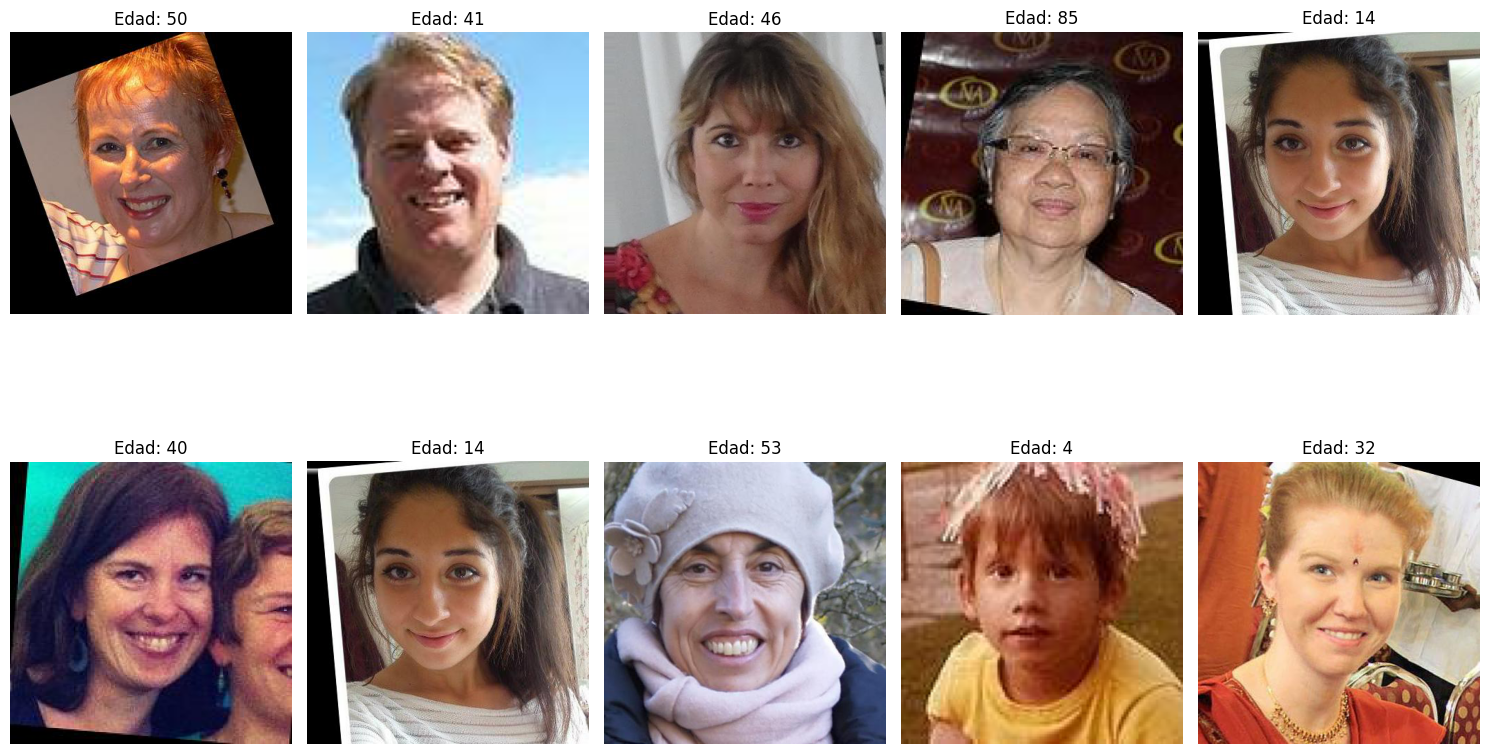

In [5]:
# Select 10 random distinct ages
random_ages = labels['real_age'].sample(10, random_state=12345).values

# Show corresponding images
plt.figure(figsize=(15, 10))
for i, age in enumerate(random_ages):
    file_name = labels[labels['real_age'] == age]['file_name'].iloc[0]
    img_path = f"/datasets/faces/final_files/{file_name}"
    img = plt.imread(img_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Edad: {age}")
    plt.axis('off')
plt.tight_layout()
plt.show()


* Images of different people with their ages annotated are provided.
* The images show a wide range of ages (from 4 to 85 years), which reinforces the variability of ages in the dataset. This is positive for training a model that can generalize to different age groups.
* Image preprocessing may play an important role in the model, as the quality and type of the image could affect the age prediction.

### Conclusions

* **a. Age Distribution**: The age distribution is skewed, which could influence the model's results if not properly adjusted. Class balancing techniques (e.g., oversampling or undersampling) may be needed to prevent the model from focusing too much on younger ages and becoming less accurate for other age groups.
* **b. Extreme Data Evaluation**: Extreme ages (e.g., 1 or 100 years) could be input errors or simply rare cases. Consider removing or correcting them, or using robust modeling techniques that can handle these values without being overly affected.
* **c. Impact of Images**: Since the images are directly related to the ages, it is crucial to preprocess them properly to improve the model's predictions. The quality, resolution, or even changes in the angle of the photo are likely to influence predictions, so appropriate image processing and computer vision models will be key.
* **d. Model Generalization**: The dataset seems to have a reasonably broad representation of ages (although more centered on younger people), which may help the model generalize well. However, it would be important to evaluate the model's accuracy across different age groups to ensure there are no significant biases.

**Recommendations for model training:**

* **Class Balancing**: Apply balancing techniques to handle the disproportionate age distribution.
* **Image Preprocessing**: Ensure images are preprocessed correctly (scaling, normalization, etc.) to improve model performance.
* **Handling Extreme Values**: Evaluate whether extreme ages need to be cleaned or treated as outliers.

## Modeling

In [ ]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
# Function to load training data
def load_train(path):
    # Read the labels (CSV file with filenames and ages)
    labels = pd.read_csv(f'{path}/labels.csv')
    
    # Set up ImageDataGenerator for image preprocessing (rescaling)
    train_datagen = ImageDataGenerator(rescale=1.0 / 255)
    
    # Create data generator for training
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}/final_files/',  # Path where images are stored
        x_col='file_name',                 # Column with filenames
        y_col='real_age',                  # Column with labels (actual age)
        target_size=(224, 224),            # Image size
        batch_size=32,                     # Batch size
        class_mode='raw',                  # Output type (for regression)
        seed=12345                         # Seed for reproducibility
    )
    
    return train_gen_flow

In [ ]:
# Function to load test data
def load_test(path):
    # Read the labels for the test set
    labels = pd.read_csv(f'{path}/labels.csv')
    
    # Set up ImageDataGenerator for image preprocessing (rescaling)
    test_datagen = ImageDataGenerator(rescale=1.0 / 255)
    
    # Create data generator for validation/test
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}/final_files/',  # Path where images are stored
        x_col='file_name',                 # Column with filenames
        y_col='real_age',                  # Column with labels (actual age)
        target_size=(224, 224),            # Image size
        batch_size=32,                     # Batch size
        class_mode='raw',                  # Output type (for regression)
        seed=12345                         # Seed for reproducibility
    )
    
    return test_gen_flow

In [ ]:
# Function to create the neural network model
def create_model(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())  # Global pooling layer
    model.add(Dense(512, activation='relu'))  # Additional dense layer to improve performance
    model.add(Dropout(0.5))  # Regularization to avoid overfitting
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])
    return model

In [ ]:
# Function to train the model
def train_model(model, train_data, test_data, batch_size=32, epochs=20, 
                steps_per_epoch=None, validation_steps=None):
    history = model.fit(
        train_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch or train_data.samples // batch_size,  
        validation_data=test_data,
        validation_steps=validation_steps or test_data.samples // batch_size  
    )
    return history


# Call functions to run the code
train_data = load_train('/datasets/faces')
test_data = load_test('/datasets/faces')

# Create and compile the model
input_shape = (224, 224, 3)
model = create_model(input_shape)

# Train the model
history = train_model(model, train_data, test_data, batch_size=32, epochs=10)

In [ ]:
# Visualization of training results
def plot_training_history(history):
    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de validación')
    plt.title('Evolución de la Pérdida')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()

    # Plot performance metric (MAE) for training and validation
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='MAE de entrenamiento')
    plt.plot(history.history['val_mae'], label='MAE de validación')
    plt.title('Evolución del Error Absoluto Medio (MAE)')
    plt.xlabel('Época')
    plt.ylabel('MAE')
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

# Call function to plot training history
plot_training_history(history)

## Prepare the script to run on the GPU platform

Once you have defined the necessary functions, you can draft a script for the GPU platform, download it via the "File|Open..." menu, and load it later to run it on the GPU platform.

Note: The script must also include the initialization section. Below is an example.

In [ ]:
import inspect

# Script to prepare and run on GPU platform
init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

# Function to load training data
def load_train(path):

    # Read the labels (CSV file with filenames and ages)
    labels = pd.read_csv(f'{path}/labels.csv')
    
    # Set up ImageDataGenerator for image preprocessing (rescaling)
    train_datagen = ImageDataGenerator(rescale=1.0 / 255)
    
    # Create data generator for training
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}/final_files/',  # Path where images are stored
        x_col='file_name',                 # Column with filenames
        y_col='real_age',                  # Column with labels (actual age)
        target_size=(224, 224),            # Image size
        batch_size=32,                     # Batch size
        class_mode='raw',                  # Output type (for regression)
        seed=12345                         # Seed for reproducibility
    )
    
    return train_gen_flow
    
# Function to load test data
def load_test(path):
    
  
    # Read the labels for the test set
    labels = pd.read_csv(f'{path}/labels.csv')
    
    # Set up ImageDataGenerator for image preprocessing (rescaling)
    test_datagen = ImageDataGenerator(rescale=1.0 / 255)
    
    # Create data generator for validation/test
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}/final_files/',  # Path where images are stored
        x_col='file_name',                 # Column with filenames
        y_col='real_age',                  # Column with labels (actual age)
        target_size=(224, 224),            # Image size
        batch_size=32,                     # Batch size
        class_mode='raw',                  # Output type (for regression)
        seed=12345                         # Seed for reproducibility
    )
    
    return test_gen_flow
    
# Function to create the neural network model
def create_model(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())  # Global pooling layer
    model.add(Dense(512, activation='relu'))  # Additional dense layer to improve performance
    model.add(Dropout(0.5))  # Regularization to avoid overfitting
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])
    return model
    
# Function to train the model
def train_model(model, train_data, test_data, batch_size=32, epochs=20, 
                steps_per_epoch=None, validation_steps=None):

    history = model.fit(
        train_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch or train_data.samples // batch_size,  # Asigna un valor por defecto
        validation_data=test_data,
        validation_steps=validation_steps or test_data.samples // batch_size  # Lo mismo aquí
    )
    return history


# Call functions to run the code
train_data = load_train('/datasets/faces')
test_data = load_test('/datasets/faces')

# Create and compile the model
input_shape = (224, 224, 3)
model = create_model(input_shape)

# Train the model
history = train_model(model, train_data, test_data, batch_size=32, epochs=10)

# Visualization of training results
def plot_training_history(history):

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de validación')
    plt.title('Evolución de la Pérdida')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()

    # Plot performance metric (MAE) for training and validation
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='MAE de entrenamiento')
    plt.plot(history.history['val_mae'], label='MAE de validación')
    plt.title('Evolución del Error Absoluto Medio (MAE)')
    plt.xlabel('Época')
    plt.ylabel('MAE')
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

# Call function to plot training history
plot_training_history(history)

"""

import inspect

# Create the script file
with open('run_model_on_gpu.py', 'w') as f:
    # Write initialization for GPU platform
    f.write(init_str)
    f.write('\n\n')
    
    # Write functions in the script
    for fn_name in [load_train, load_test, create_model, train_model]:
        src = inspect.getsource(fn_name)  # Get source code of each function
        f.write(src)
        f.write('\n\n')

print("Script 'run_model_on_gpu.py' preparado para la ejecución en la plataforma GPU.")